In [1]:
import autograd as ad
import autograd.variable as av
import numpy as np

In [2]:
def loss_function(params):
    var = av.Variable(params)
    x, y = var[0], var[1]
    
    b1 = ad.exp(-0.1*((x**2)+(y**2)))
    b2 = ad.cos(0.5*(x+y))
    b3 = b1*b2+0.1*(x+y)+ad.exp(0.1*(3-(x+y)))
    
    b3.compute_gradients()
    return (b3.data, b3.gradient)

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer) 

In [4]:
from autograd.optimize import GD, Adam

In [5]:
def plot_nice_surface_and_gradients(f, x_lims=[-5, 5], y_lims=[-5, 5], iterations=50, startingPoint=[0.1,-0.1], 
                                   title='vector function plus gradient descent algorithm',
                                   solver='adam',
                                   lr=0.1):
    x=np.linspace(x_lims[0],x_lims[1],100)
    y=np.linspace(y_lims[0],y_lims[1],100)

    X,Y=np.meshgrid(x,y)
        
    def data_function(a, b):
        data, grad= f([a, b])
        return(data)
    
    vf=np.vectorize(data_function)

    Z=vf(X,Y)

    fig = plt.figure(figsize=(12,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

    fig.colorbar(surf, shrink=0.5, aspect=5)

    if solver=='adam':
        optimizer = Adam(f, startingPoint, lr=lr, max_iter=iterations)
    elif solver=='gd':
        optimizer = GD(f, startingPoint, lr=lr, max_iter=iterations)
    else:
        raise ValueError('Encountered unexpected solver flag.')
    
    soln, steps = optimizer.solve(return_steps=True)
    for i in range(1, len(steps)):
        x, x_n = steps[i-1][0], steps[i][0]
        y, y_n = steps[i-1][1], steps[i][1]
        z, z_n = data_function(x, y), data_function(x_n, y_n)
        
        a = Arrow3D([x, x_n], [y, y_n],
                   [z, z_n], mutation_scale=20,
                   lw=1, arrowstyle="-|>", color="r")
        ax.add_artist(a)
        
    ax.add_artist(a)
    plt.draw()
    plt.show()

## Simple, well conditioned problem

$$f(x,y)=\cos(0.5\cdot(x+y)) \cdot e^{(-0.1\cdot(x^2 + y^2))}+ 0.1\cdot(x+y) + e^{(0.1 \cdot(3-(x+y))}$$

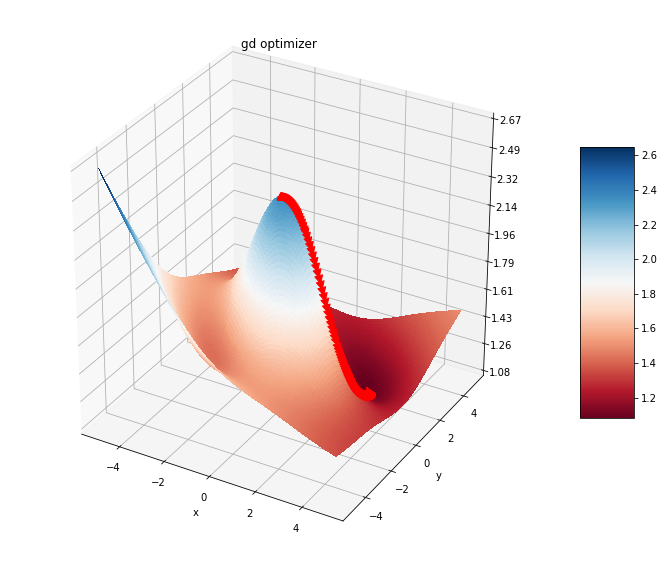

In [6]:
plot_nice_surface_and_gradients(loss_function, 
                                title='gd optimizer', 
                                solver='gd',
                                lr=0.1,
                                iterations=1000)

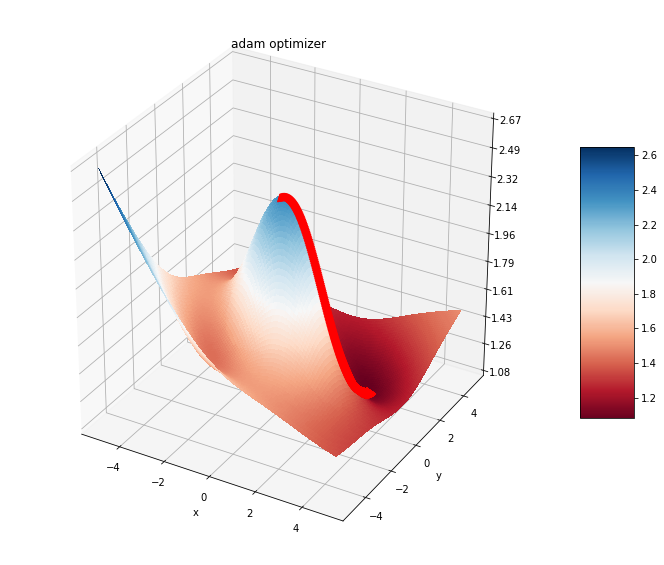

In [7]:
plot_nice_surface_and_gradients(loss_function, 
                                title='adam optimizer', 
                                solver='adam', 
                                lr=0.01,
                                iterations=1000)

## Different starting points

### Non-convergence of GD!

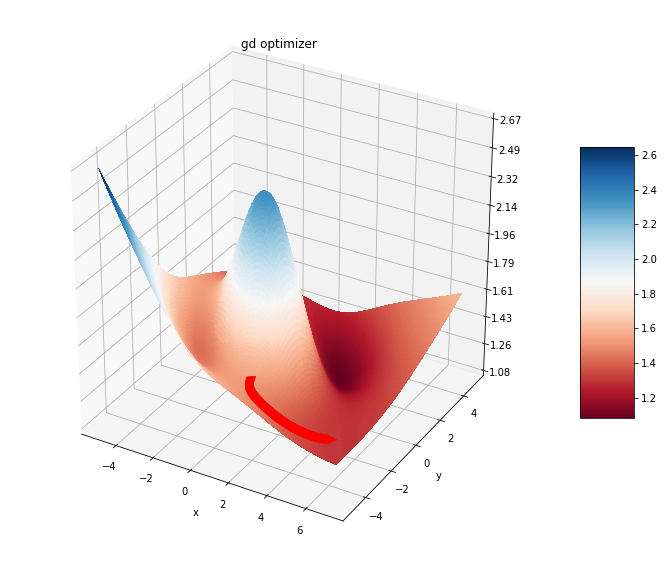

In [8]:
plot_nice_surface_and_gradients(loss_function, 
                                x_lims=[-5,7],
                                title='gd optimizer', 
                                solver='gd',
                                startingPoint=[2,-4],
                                lr=0.1,
                                iterations=1000)

### Adam converges!

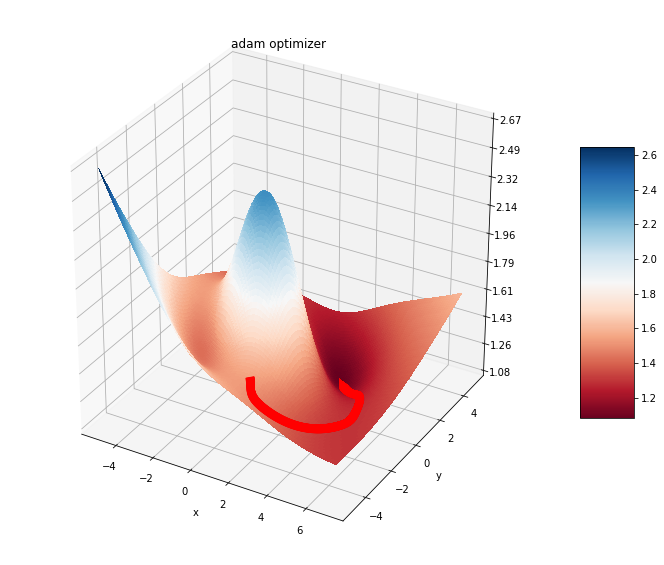

In [9]:
plot_nice_surface_and_gradients(loss_function,
                                x_lims=[-5, 7],
                                title='adam optimizer', 
                                solver='adam', 
                                startingPoint=[2,-4],
                                lr=0.01,
                                iterations=1000)

### 10x Iterations for GD and still does not converge!

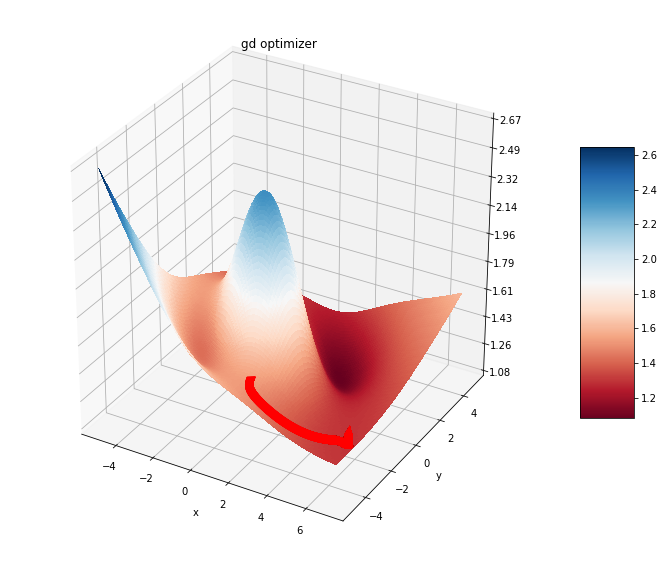

In [10]:
plot_nice_surface_and_gradients(loss_function,
                                x_lims=[-5, 7],
                                title='gd optimizer', 
                                solver='gd',
                                startingPoint=[2,-4],
                                lr=0.1,
                                iterations=10000)

## Beale Function

$$f(x,y) = (1.5-x+x \cdot y)^2 + (2.25 - x + x \cdot y^2)^2 + (2.625 - x + x \cdot y^3)^2 $$

In [11]:
def beale_function(params):
    var = av.Variable(params)
    x, y = var[0], var[1]
    
    b1 = (1.5-x+x*y)**2
    b2 = (2.25-x+x*(y**2))**2
    b3 = (2.625-x+x*(y**3))**2
    b4 = b1 + b2 + b3
    
    b4.compute_gradients()
    return (b4.data, b4.gradient)

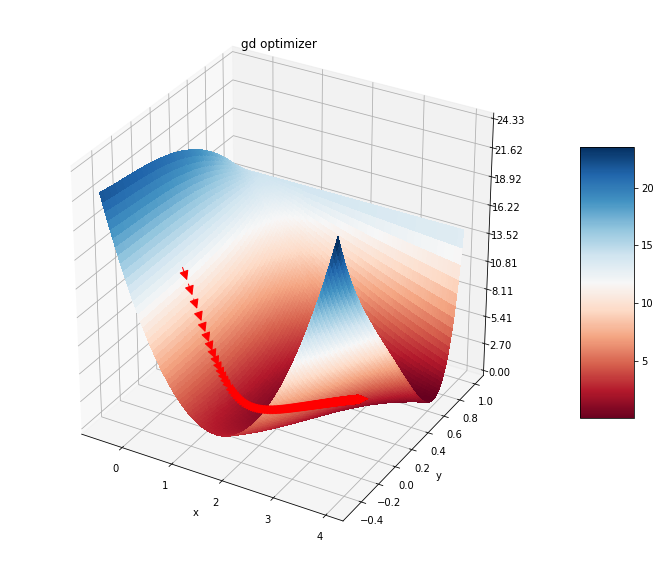

In [12]:
plot_nice_surface_and_gradients(beale_function,
                                x_lims=[-0.5, 4],
                                y_lims=[-0.5, 1],
                                startingPoint=[0,0],
                                title='gd optimizer', 
                                solver='gd', 
                                lr=0.01,
                                iterations=1000)

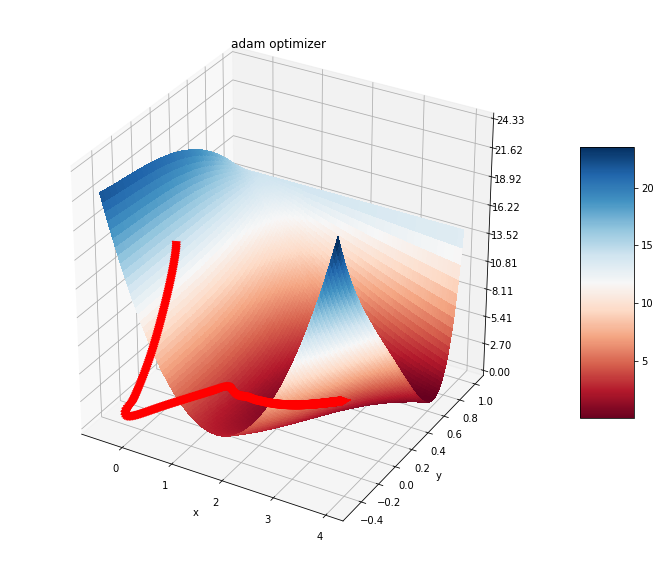

In [13]:
plot_nice_surface_and_gradients(beale_function,
                                x_lims=[-0.5, 4],
                                y_lims=[-0.5, 1],
                                startingPoint=[0,0],
                                title='adam optimizer', 
                                solver='adam', 
                                lr=0.01,
                                iterations=1000)

### Enough with the pictures, show me some real convergence results:

- inspired by https://en.wikipedia.org/wiki/Test_functions_for_optimization and https://arxiv.org/pdf/1609.04747.pdf

In [18]:
from tqdm import tqdm
import time
def compute_convergence_results(loss_func, start_samples, optimal_solution,
                               gd_lr=0.001, adam_lr=0.001, max_iters=10000):
    """ GD and Adam both use lr=0.001 and max_iter=1000 """
    n_samps = len(start_samples)
    
    print('Running for loss func: {}...'.format(loss_func))
    gd_times=[]
    adam_times=[]
    gd_sols=[]
    adam_sols=[]
    for s in tqdm(start_samples):
        # gradient descent
        gd = GD(loss_function, s, lr=gd_lr, max_iter=max_iters)
        start = time.time()
        gd_sols.append(gd.solve())
        gd_times.append(time.time() - start)
        
        # adam
        adam = Adam(beale_function, s, lr=adam_lr, max_iter=max_iters)
        start = time.time()
        adam_sols.append(adam.solve())
        adam_times.append(time.time() - start)
        
    print('Computing convergence rates...')
    gd_converged, adam_converged = 0, 0
    for gsol, asol in zip(gd_sols, adam_sols):
        if all(np.round(gsol) == np.round(optimal_sol)):
            gd_converged += 1
        if all(np.round(asol) == np.round(optimal_sol)):
            adam_converged += 1
    
    return {'gd_time': np.mean(gd_times), 'adam_time': np.mean(adam_times),
            'gd_converge_pct':100*gd_converged/n_samps, 'adam_converge_pct':100*adam_converged/n_samps}
        

### Beale Function

$$f(x,y) = (1.5-x+x \cdot y)^2 + (2.25 - x + x \cdot y^2)^2 + (2.625 - x + x \cdot y^3)^2 $$

In [19]:
start_samps = np.random.multivariate_normal([0, 0], [[3, 0], [0, 3]], size=50)

In [20]:
optimal_sol = [3, 0.5]

In [21]:
result_dict = compute_convergence_results(beale_function, start_samps, optimal_sol)

  0%|          | 0/50 [00:00<?, ?it/s]

Running for loss func: <function beale_function at 0x11c2a77b8>...


100%|██████████| 50/50 [17:02<00:00, 19.86s/it]

Computing convergence rates...


In [22]:
result_dict

{'gd_time': 10.602183365821839,
 'adam_time': 9.852936873435974,
 'gd_converge_pct': 0.0,
 'adam_converge_pct': 48.0}

In [23]:
results={}
results['beale_function']=result_dict

### Our loss function (non-convex)

$$f(x,y)=\cos(0.5\cdot(x+y)) \cdot e^{(-0.1\cdot(x^2 + y^2))}+ 0.1\cdot(x+y) + e^{(0.1 \cdot(3-(x+y))}$$

In [24]:
start_samps = np.random.multivariate_normal([0, 0], [[3, 0], [0, 3]], size=50)

In [25]:
optimal_sol = [2.326, 2.326]

In [26]:
new_results = compute_convergence_results(loss_function, start_samps, optimal_sol)

  0%|          | 0/50 [00:00<?, ?it/s]

Running for loss func: <function loss_function at 0x10e0d7c80>...


100%|██████████| 50/50 [17:08<00:00, 20.98s/it]

Computing convergence rates...


In [27]:
new_results

{'gd_time': 10.59706238269806,
 'adam_time': 9.965554542541504,
 'gd_converge_pct': 18.0,
 'adam_converge_pct': 0.0}

In [28]:
results['our_loss_function']=new_results

### Booth function

$$f(x,y) = (x + 2\cdot y - 7)^2 + (2 \cdot x + y - 5)^2 $$

In [29]:
def booth_function(params):
    var = av.Variable(params)
    x, y = var[0], var[1]
    
    b1 = (x + 2*y - 7)**2
    b2 = (2*x + y - 5)**2
    b3 = b1 + b2
    
    b3.compute_gradients()
    return (b3.data, b3.gradient)

In [30]:
start_samps = np.random.multivariate_normal([0, 0], [[10, 0], [0, 10]], size=50)

In [31]:
optimal_sol = [1, 3]

In [32]:
new_results = compute_convergence_results(booth_function, start_samps, optimal_sol)

  0%|          | 0/50 [00:00<?, ?it/s]

Running for loss func: <function booth_function at 0x11c7dac80>...


100%|██████████| 50/50 [17:01<00:00, 20.78s/it]

Computing convergence rates...


In [33]:
new_results

{'gd_time': 10.4947141122818,
 'adam_time': 9.929561886787415,
 'gd_converge_pct': 2.0,
 'adam_converge_pct': 0.0}

In [34]:
results['booth_function']=new_results

### Goldstein-Price Function

$$ f(x,y) = \left[1 + (x+y+1)^{2} \cdot (19 - 14x + 3x^2 - 14y + 6xy + 3y^{2} \right] \cdot \left[30 + (2x-3y)^{2} \cdot (18 - 32x + 12x^2 + 48y - 36xy + 27y^2 \right] $$

In [36]:
def goldstein_function(params):
    var = av.Variable(params)
    x, y = var[0], var[1]
    
    b1 = 1 + ((x + y + 1)**2)*(19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)
    b2 = 30 + ((2*x - 3*y)**2)*(18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)
    b3 = b1*b2
    
    b3.compute_gradients()
    return (b3.data, b3.gradient)

In [37]:
start_samps = np.random.multivariate_normal([0, 0], [[2, 0], [0, 2]], size=50)

In [38]:
optimal_sol = [0, -1]

In [ ]:
new_results = compute_convergence_results(goldstein_function, start_samps, optimal_sol)

  0%|          | 0/50 [00:00<?, ?it/s]

Running for loss func: <function goldstein_function at 0x11ce6ab70>...


  6%|▌         | 3/50 [01:00<15:50, 20.22s/it]

In [ ]:
new_results

In [ ]:
results['goldstein-price function']=new_results